# Stock-Price - Time Series Analysis and Modelling

    - Averaging and smoothing models, ARIMA models (statistical time-series modeling)

In [1]:
# ignore warnings
from warnings import filterwarnings
filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit

import statsmodels.formula.api as smf # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import scipy.stats as scs

from itertools import product
from tqdm import tqdm_notebook

# set plotting style
%matplotlib inline
sns.set()

# set formatting
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [2]:
# MAPE metric
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Read and Process data

In [3]:
stock_price = pd.read_csv('Infy_raw.csv')
stock_price['Date'] = pd.to_datetime(stock_price['Date'], format='%d-%m-%Y')
stock_price.drop(['Symbol', 'Series', 'Prev Close', 'Open', 'High', 'Low', 'Last', 'VWAP', 'Volume', 'Turnover', 'Trades', 'Deliverable Volume', '%Deliverble'], axis=1, inplace=True)
stock_price.index = stock_price['Date']

## Time Series Analysis

In [4]:
# look at data
stock_price.head()

,Date,Close
Date,,
2014-01-01,2014-01-01,433.50000
2014-01-02,2014-01-02,435.06875
2014-01-03,2014-01-03,445.64375
2014-01-06,2014-01-06,439.73750
2014-01-07,2014-01-07,432.14375


In [5]:
# look a shape of data
stock_price.shape

(1300, 2)

In [6]:
# look at data types
stock_price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1300 entries, 2014-01-01 to 2019-04-05
Data columns (total 2 columns):
Date     1300 non-null datetime64[ns]
Close    1300 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 30.5 KB


In [7]:
# see if any columns have nulls.
stock_price.isnull().any()

Date     False
Close    False
dtype: bool

### Plot data
* Appears to be an overall increasing trend.
* Clearly, you see that this is not a stationary process, and it is hard to tell if there is some kind of seasonality.

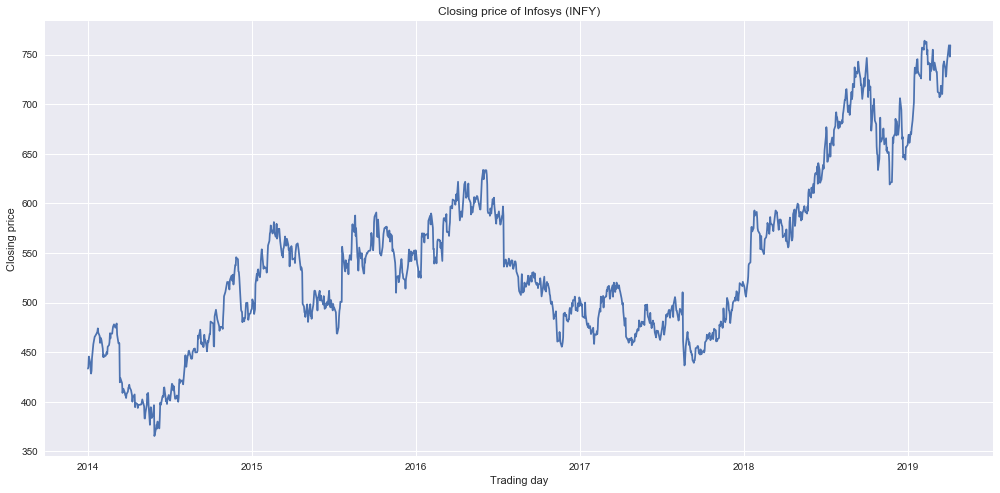

In [8]:
# Show graph
plt.figure(figsize=(17, 8))
plt.plot(stock_price.Close)
plt.title('Closing price of Infosys (INFY)')
plt.ylabel('Closing price')
plt.xlabel('Trading day')
plt.grid(True)
plt.show()
plt.close()

### Look at stationarity (A time series with a trend is called non-stationary)

Stationarity is a statistical assumption that a time-series has:
- Constant mean
- Constant variance
- Autocovariance does not depend on time

#### Summary Statistics

In [9]:
split = int(len(stock_price) / 2)
X1, X2 = stock_price['Close'][0:split], stock_price['Close'][split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=512.167731, mean2=566.904077
variance1=4122.179548, variance2=9255.581877


#### Augmented Dickey-Fuller test

In [10]:
def test_stationarity(df, ts):
    """
    Test stationarity using moving average statistics and Dickey-Fuller test
    Source: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    """
    
    # Determing rolling statistics
    rolmean = df[ts].rolling(window = 12, center = False).mean()
    rolstd = df[ts].rolling(window = 12, center = False).std()
    
    # Plot rolling statistics:
    orig = plt.plot(df[ts], 
                    color = 'blue', 
                    label = 'Original')
    mean = plt.plot(rolmean, 
                    color = 'red', 
                    label = 'Rolling Mean')
    std = plt.plot(rolstd, 
                   color = 'black', 
                   label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation for %s' %(ts))
    plt.xticks(rotation = 45)
    plt.show(block = False)
    plt.close()
    
    # Perform Dickey-Fuller test:
    # Null Hypothesis (H_0): time series is not stationary
    # Alternate Hypothesis (H_1): time series is stationary
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(df[ts], 
                      autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index = ['Test Statistic',
                                  'p-value',
                                  '# Lags Used',
                                  'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

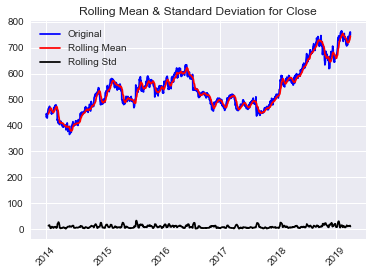

Results of Dickey-Fuller Test:
Test Statistic                   -0.834694
p-value                           0.808718
# Lags Used                       2.000000
Number of Observations Used    1297.000000
Critical Value (1%)              -3.435402
Critical Value (5%)              -2.863771
Critical Value (10%)             -2.567958
dtype: float64


In [11]:
test_stationarity(df = stock_price, ts = 'Close')

#### Decomposing to choose the model (ARMA/ARIMA/SARIMA/etc)

y(t) = Level × Trend × Seasonality × Noise

* Level: The average value in the series.
* Trend: The increasing or decreasing value in the series.
* Seasonality: The repeating short-term cycle in the series. 􏰀 
* Noise: The random variation in the series.

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

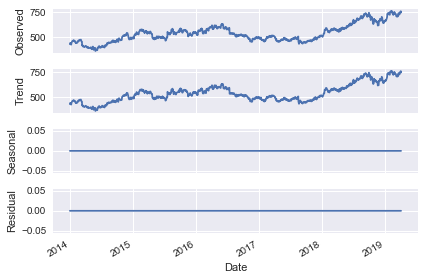

In [13]:
result = seasonal_decompose(stock_price['Close'], model='additive', freq=1)
result.plot()
plt.show()

we are gonna use ARIMA model since it is non-stationary and there is no seasonality

#### Determine p, q and d for ARIMA

A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used. The parameters of the ARIMA model are defined as follows:
􏰀
- p: The number of lag observations included in the model, also called the lag order.
- d: The number of times that the raw observations are differenced, also called the degree
of differencing.
- q: The size of the moving average window, also called the order of moving average.

##### Detrend by Differencing to determine 'd'

In [16]:
stock_price["LogPrice"] = np.log(stock_price.Close)

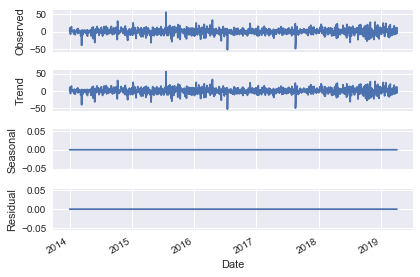

In [72]:
stock_price['Diff'] = stock_price.Close - stock_price.Close.shift(1)

result = seasonal_decompose(stock_price['Diff'][1:], model='additive', freq=1)
result.plot()
plt.show()

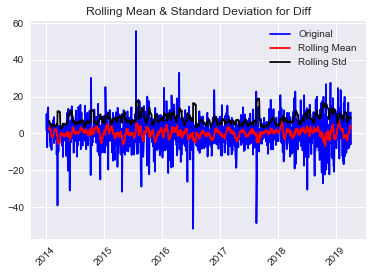

Results of Dickey-Fuller Test:
Test Statistic                  -27.333927
p-value                           0.000000
# Lags Used                       1.000000
Number of Observations Used    1297.000000
Critical Value (1%)              -3.435402
Critical Value (5%)              -2.863771
Critical Value (10%)             -2.567958
dtype: float64


In [73]:
test_stationarity(df = stock_price.dropna(), ts = 'Diff')

p-value ≤ 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

ideal value for d would be 1

##### ACF and PACF to determine p and q

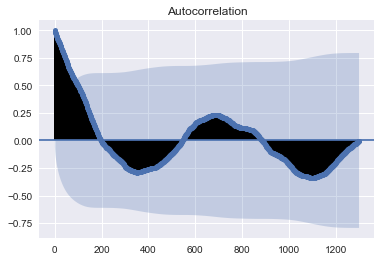

In [74]:
# ACF plot of time series
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
series = stock_price.Close
plot_acf(series)
pyplot.show()

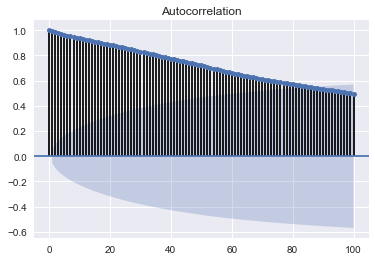

In [75]:
# ACF plot of time series
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
series = stock_price.Close
plot_acf(series, lags=100)
pyplot.show()

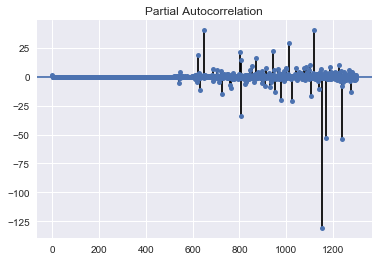

In [76]:
# PACF plot of time series
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_pacf
series = stock_price.Close
plot_pacf(series)
pyplot.show()

In [1]:
# PACF plot of time series
series = stock_price.Close
plot_pacf(series, lags=50)
pyplot.show()

NameError: name 'stock_price' is not defined

we can try different options of p and q to determine the best model with low MAPE 

## Time Series Forecasting

### ARIMA - find the optimal value for p, q and d

In [78]:
import warnings
warnings.filterwarnings("ignore")

In [79]:
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = 1000
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    mape = sqrt(mean_absolute_percentage_error(test, predictions)) 
    return rmse, mape

In [80]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values): 
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse, mape = evaluate_arima_model(dataset, order)
                    if mape < best_score:
                        best_score, best_cfg = mape, order 
                        print('ARIMA%s MAPE=%.3f' % (order,mape))
                except:
                    print('Skipped %s' % (order))
                    continue
    print('Best ARIMA%s MAPE=%.3f' % (best_cfg, best_score))

In [23]:
# evaluate parameters
p_values = [0, 1, 2]
d_values = range(1, 3)
q_values = range(0, 1)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 1, 0) MAPE=3.303
ARIMA(2, 1, 0) MAPE=3.303
Best ARIMA(2, 1, 0) MAPE=3.303


### Fit the model with best parameters

In [81]:
p, d, q = 12, 1,1

predicted=574.164575, expected=576.350000
predicted=574.837028, expected=571.725000
predicted=570.289340, expected=575.000000
predicted=574.281134, expected=588.550000
predicted=588.473037, expected=592.900000
predicted=591.156411, expected=587.700000
predicted=586.364765, expected=591.450000
predicted=592.116569, expected=585.325000
predicted=584.896995, expected=575.125000
predicted=574.901852, expected=572.300000
predicted=572.905403, expected=571.625000
predicted=572.464955, expected=569.100000
predicted=569.888286, expected=553.875000
predicted=553.718766, expected=554.525000
predicted=555.846214, expected=567.125000
predicted=568.353052, expected=554.575000
predicted=554.221310, expected=551.400000
predicted=552.852710, expected=548.875000
predicted=549.711296, expected=557.225000
predicted=558.553066, expected=564.025000
predicted=563.693024, expected=565.875000
predicted=565.254678, expected=568.475000
predicted=568.872957, expected=573.700000
predicted=574.192274, expected=580

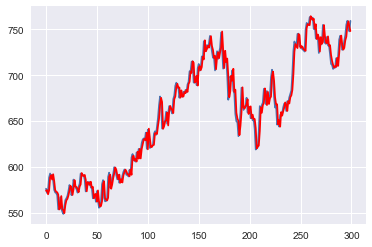

In [82]:
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt

# evaluate an ARIMA model using a walk-forward validation

series = stock_price.Close

# split into train and test sets
X = series.values
size = 1000
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    #history = history[-30:] # to pull last 30 days
    model = ARIMA(history, order=(p, d, q))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions)) 
print('Test RMSE: %.3f' % rmse)
mape = sqrt(mean_absolute_percentage_error(test, predictions)) 
print('Test MAPE: %.3f' % mape)
# plot forecasts against actual outcomes 
pyplot.plot(test)
pyplot.plot(predictions, color='red') 
pyplot.show()

In [83]:
test_df = pd.DataFrame(test, columns=['Actual'])

In [84]:
test_df.shape

(300, 1)

In [85]:
test_df['Predictions'] = [i[0] for i in predictions]

In [86]:
test_df.head()

,Actual,Predictions
0,576.350,574.164575
1,571.725,574.837028
2,575.000,570.289340
3,588.550,574.281134
4,592.900,588.473037


In [87]:
test_df['ActualTrend'] = test_df['Actual'] - test_df['Actual'].shift(1)
test_df['PredictionTrend'] = test_df['Predictions'] - test_df['Actual'].shift(1)

In [88]:
test_df['ActualTrend'] = test_df['ActualTrend'].shift(-1)
test_df['PredictionTrend'] = test_df['PredictionTrend'].shift(-1)

In [89]:
test_df.head(10)

,Actual,Predictions,ActualTrend,PredictionTrend
0,576.350,574.164575,-4.625,-1.512972
1,571.725,574.837028,3.275,-1.435660
2,575.000,570.289340,13.550,-0.718866
3,588.550,574.281134,4.350,-0.076963
4,592.900,588.473037,-5.200,-1.743589
5,587.700,591.156411,3.750,-1.335235
6,591.450,586.364765,-6.125,0.666569
7,585.325,592.116569,-10.200,-0.428005
8,575.125,584.896995,-2.825,-0.223148
9,572.300,574.901852,-0.675,0.605403


In [90]:

test_df.dropna(inplace=True)
test_df['ActualTrend'] = test_df['ActualTrend'].apply(lambda x: 'Up' if x >= 0 else 'Down')
test_df['PredictionTrend'] = test_df['PredictionTrend'].apply(lambda x: 'Up' if x >= 0 else 'Down')

In [91]:
from sklearn.metrics import accuracy_score

### Accuracy of the Model

In [92]:
accuracy_score(test_df['ActualTrend'], test_df['PredictionTrend'])

0.5752508361204013

In [93]:
test_df.head()

,Actual,Predictions,ActualTrend,PredictionTrend
0,576.350,574.164575,Down,Down
1,571.725,574.837028,Up,Down
2,575.000,570.289340,Up,Down
3,588.550,574.281134,Up,Down
4,592.900,588.473037,Down,Down


In [94]:
test_df.to_csv("arima_12.csv")

In [95]:
from sklearn.metrics import confusion_matrix

In [96]:
confusion_matrix(test_df['ActualTrend'], test_df['PredictionTrend'])

array([[ 67,  67],
       [ 60, 105]], dtype=int64)

In [97]:
from sklearn import metrics

In [98]:
print(metrics.classification_report(test_df['ActualTrend'], test_df['PredictionTrend']))

             precision    recall  f1-score   support

       Down       0.53      0.50      0.51       134
         Up       0.61      0.64      0.62       165

avg / total       0.57      0.58      0.57       299

